In [1]:
# Barren Plateaus Data Analysis

## Load Data

import matplotlib as mpl
mpl.rc("savefig", dpi=500)
%matplotlib inline

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from collections import Counter
import glob
import ast


plt.rcParams['figure.dpi'] = 150
plt.rcParams['savefig.dpi'] = 150

data_path = './bps/maxcut/'
sns.set_palette('viridis', n_colors=100)

def array_interpret(s: str) -> np.array:
    try:
        return np.array(ast.literal_eval(f'[{s}]'))[0]
    except:
        return np.array([])

def interpret_complex(s:str) -> float:
    if '+' in s:
        re, im = s.split('+')
        re = float(re)
        im = im.rstrip(" ")[0:-2]
        im = float(im)
        if abs(im) > 0.0:
            raise ValueError("Non-zero imaginary component!!!")
    else:
        re = float(s)
    return re

def gate_counts(l):
    n = len(l[0])
    return Counter(map(lambda s: n - s.count("I"), l))

In [2]:
num_instances = len(glob.glob(data_path+"8/nchoose2local/*"))

In [3]:
num_instances

200

In [4]:
""" `df_result` contains information about the final convergence properties
of ADAPT-VQE. This includes information about the success of the ADAPT-VQE
algorithm.

`df_adapt` contains information collected during the outer loop of
ADAPT-VQE, for example gradients computed and operators selected, etc.
"""


df_result = None
df_adapt = None

for exact_file_path in glob.glob(data_path+'**/exact_result.csv', recursive=True):
    _, _, ham, num_qubits, pool, seed, _ = exact_file_path.split("/")
    adapt_file_path = exact_file_path.split('exact')[0] + 'adapt_history.csv'
    num_qubits = int(num_qubits)
    seed = int(seed)
    
    _df_result_1 = pd.read_csv(exact_file_path, delimiter=';', converters={
        ' min_bs': str, ' min_val': interpret_complex})
    try:
        _df_result_2 = pd.read_csv(adapt_file_path, delimiter=';')
    except:
        continue
    _df_result_1.rename(columns=lambda x: x.lstrip(' '), inplace=True)
    _df_result_2.rename(columns=lambda x: x.lstrip(' '), inplace=True)
    
    _df_result_1['num_qubits'] = num_qubits
    _df_result_1['seed'] = seed
    _df_result_1['min_bs'] = _df_result_1['min_bs'].map(lambda bs: bs.rjust(num_qubits, '0'))
    
    #####################
    # Process Pauli lists
    if len(_df_result_1) > 1:
        raise ValueError("Hmm...")
    _df_result_1['pauli_list'] = [None] * len(_df_result_1)
    _df_result_1['pauli_list'] = [list(map(lambda s: s.lstrip(), list(_df_result_2['paulis'])))]
    _df_result_1['two_local_op_count'] = _df_result_1['pauli_list'].map(lambda g: gate_counts(g)[2])
    #####################
    
    _df_adapt = pd.concat([pd.concat([_df_result_1]*len(_df_result_2), ignore_index=True), _df_result_2], axis=1, )
    
    if df_adapt is None:
        df_adapt = _df_adapt
    else:
        df_adapt = pd.concat([df_adapt, _df_adapt])
    
df_adapt.reset_index(inplace=True)
df_adapt.drop(columns='index', inplace=True)
df_adapt = df_adapt[df_adapt['opt_numevals'] != ' nothing']
df_adapt['grads'] = df_adapt['grads'].map(array_interpret)
df_adapt['opt_pars'] = df_adapt['opt_pars'].map(array_interpret)
df_adapt['opt_numevals'] = df_adapt['opt_numevals'].map(int)
df_adapt['norm_c'] = df_adapt['energy'] / df_adapt['min_val']


for name, group in df_adapt.groupby(['num_qubits', 'seed']):
    num_qubits, seed = name
    num_layers = max(group['layer'])
    group = group[group['layer'] == num_layers]
    if df_result is None:
        df_result = group
    else:
        df_result = pd.concat([group, df_result])

df_adapt.drop(columns=['pauli_list', 'two_local_op_count'], inplace=True)

df_adapt['num_qubits'].value_counts()

df_result['num_qubits'].value_counts()

#df_layerwise['num_qubits'].value_counts()

14    200
12    200
10    200
8     200
6     200
4     200
Name: num_qubits, dtype: int64

# Performance

## Approximation Ratio

This plot demonstrates the success of the ADAPT-VQE algorithm on the family of max cut Hamiltonians. The y axis is the approximation ratio, which measures performance. It is calculated by taking the value of the cost function determined by the algorithm and dividing by the exact answer. This means that `1.0` is a perfect result.

We can see that for all numbers of qubits considered, the approximation ratio goes roughly to `1.0`. This means that on average, the algorithm succeeds with sufficiently many layers of ADAPT.

It is natural to ask: How many layers is sufficient to converge, as a function of the number of qubits?

(Compare with Fig 5 https://arxiv.org/pdf/2004.04197.pdf)

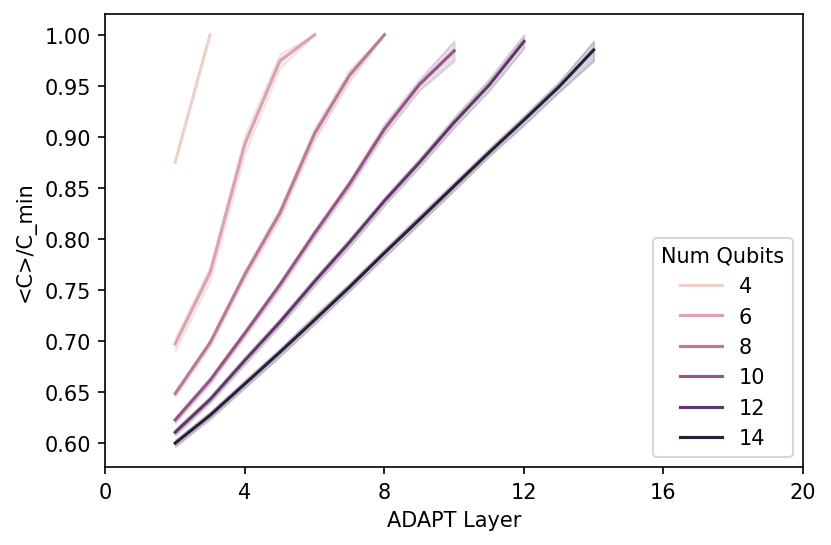

In [5]:
ax = sns.lineplot(data=df_adapt, x='layer', y='norm_c', hue='num_qubits')
#ax = sns.scatterplot(data=df_adapt, x='layer', y='norm_c', hue='num_qubits')
ax.set_xlabel("ADAPT Layer")
ax.set_ylabel("<C>/C_min")
ax.set_xticks(np.arange(0, 20+1, step=4))
ax.legend(title="Num Qubits", loc='lower right');

## Layers to Convergence

Now we can take the above data and consider only the approximation ratio at final layer of ADAPT, i.e. the actual result. As a function of the number of qubits, the number of layers needed to converge ADAPT fits well to a linear regression. The implication of this result is that for the setup considered, ADAPT requires circuits of depth `O(n)`.

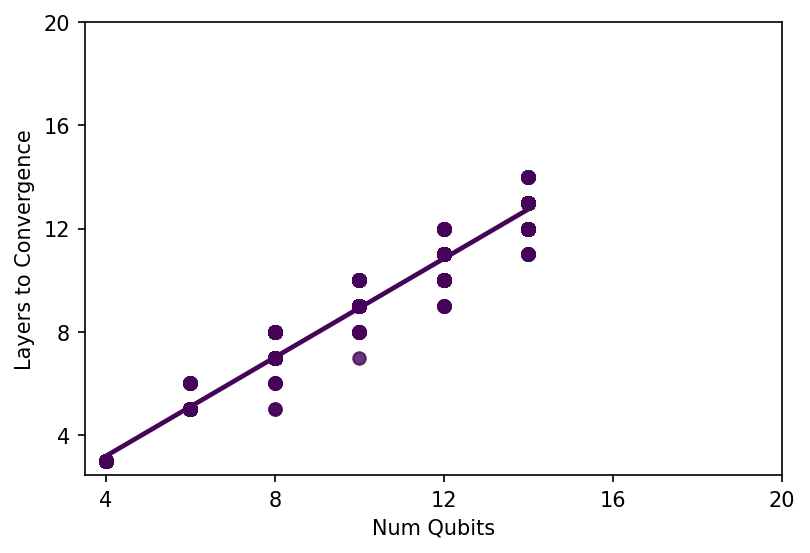

In [6]:
ax = sns.regplot(data=df_result, x='num_qubits', y='layer')
ax.set_xlabel("Num Qubits")
ax.set_ylabel("Layers to Convergence")
ax.set_xticks(np.arange(4, 20+1, step=4))
ax.set_yticks(np.arange(4, 20+1, step=4));

## Detail of Approximation Ratio

Now let's take a closer look at the final value of the approximation ratio. Here we consider the final result as a function of the number of qubits. There are two plots on this figure, both representing the same information. The solid line with the shaded region are the mean of the approximation ratio for that number of qubits and the 95% confidence interval for the data, respectively. The dots are the raw data.

This plot tells us that on average, the approximation ratio consistently stays above `0.9`. However, there are some exceptions to this statement for larger numbers of qubits. More interestingly, there seem to be three clusters of data. I do not yet have an explanation for this.

It is important to note that there are many dots clustered around and approximation ratio of `1.0`. For example, for 20 qubits, 60% of the data are at an approximation ratio of `1.0`.

(Compare with Fig 4 https://arxiv.org/pdf/2004.04197.pdf)

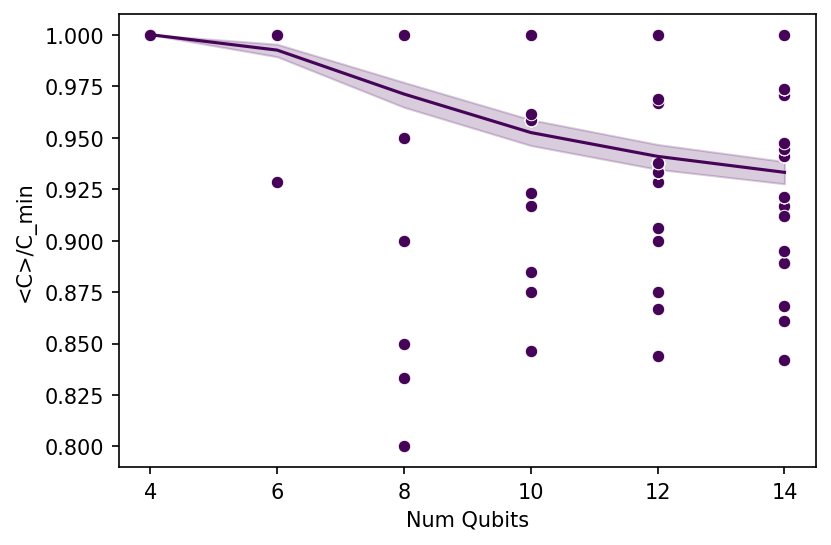

In [7]:
ax = sns.lineplot(data=df_result, x='num_qubits', y='norm_c')
ax = sns.scatterplot(data=df_result, x='num_qubits', y='norm_c')
#ax = sns.boxplot(data=df_result, x='num_qubits', y='norm_c', whis=np.inf)
ax.set_xlabel("Num Qubits")
ax.set_ylabel("<C>/C_min");
#ax.set_xticks(np.arange(0, 20+1, step=4));
#ax.set_ylim(0, 1)

# Inner Loop Analysis

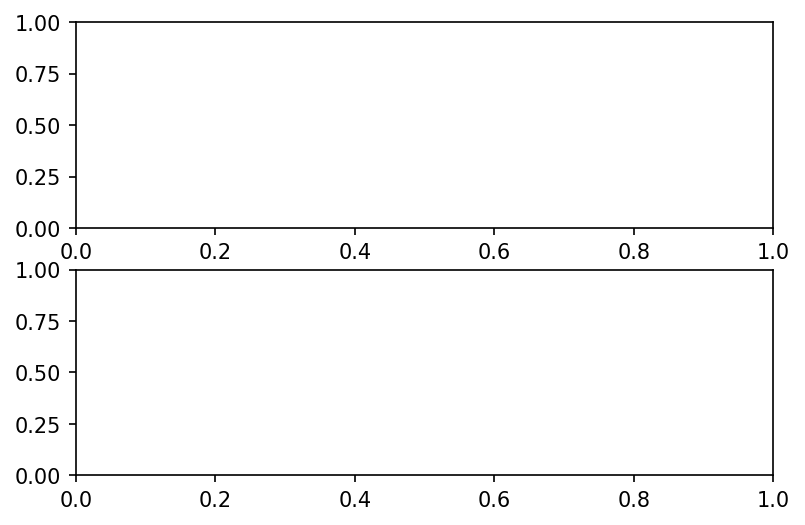

In [19]:
fig, axes = plt.subplots(nrows=2)

## Gradient Convergence - VQE Sampling

In [20]:
import h5py

In [21]:
df_cost_list = []
df_grad_list = []

for fn in glob.glob("./bps/maxcut/**/vqe_*.h5", recursive=True):
    _, _, _, num_qubits, pool, seed, vqe_layer_ind = fn.split("/")
    layer = int(vqe_layer_ind.split("_")[2].split(".")[0])
    f = h5py.File(fn, 'r')
    
    _df_cost = pd.DataFrame(f["fn_evals"], columns=["fn_eval"])
    _df_grad = pd.DataFrame(f["grad_evals"], columns=["grad_eval"])
    
    for _df in [_df_grad]:
        _df["num_qubits"] = int(num_qubits)
        _df["pool"] = pool
        _df["seed"] = int(seed)
        _df["layer"] = layer
        _df["abs_grad_eval"] = _df["grad_eval"].map(abs)
        _df["log_grad_eval"] = _df["abs_grad_eval"].map(lambda x: np.log10(x + 1e-20))
        df_grad_list.append(_df)
    
    for _df in [_df_cost]:
        _df["num_qubits"] = int(num_qubits)
        _df["pool"] = pool
        _df["seed"] = int(seed)
        _df["layer"] = layer
        df_cost_list.append(_df)

df_cost = pd.concat(df_cost_list)
df_grad = pd.concat(df_grad_list)

In [22]:
df_stat_cost = df_cost.drop(columns=["seed"]).groupby(["layer", "num_qubits"]).aggregate(["mean", "var"])
df_stat_grad = df_grad.drop(columns=["seed"]).groupby(["layer", "num_qubits"]).aggregate(["mean", "var"])

Text(0.5, 1.0, 'ADAPT with Max-Cut Hamiltonian, 200 instances (for each n)')

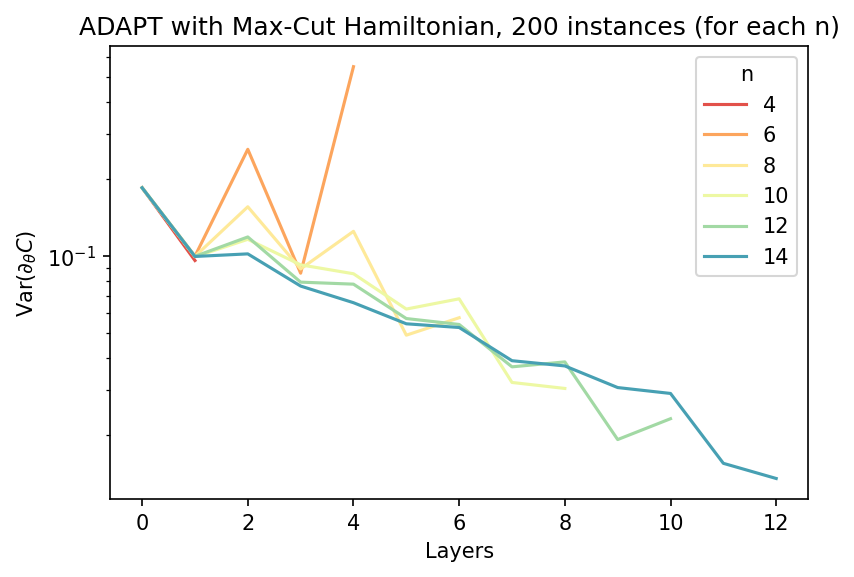

In [23]:

ax = sns.lineplot(
    data=df_stat_grad.grad_eval,
    x="layer",
    hue="num_qubits",
    y="var",
    palette=sns.color_palette("Spectral", n_colors=len(df_grad["num_qubits"].unique()))
)

ax.set_xlabel("Layers")
ax.set_ylabel(r'Var$(\partial_\theta C)$')
ax.set_yscale("log")
ax.legend().set_title("n")
ax.set_title(f"ADAPT with Max-Cut Hamiltonian, {num_instances} instances (for each n)")

## Gradient Convergence - VQE Sampling

In [24]:
import h5py

In [25]:
df_cost_list = []
df_grad_list = []

for fn in glob.glob("./bps/maxcut/**/rand_*.h5", recursive=True):
    _, _, _, num_qubits, pool, seed, vqe_layer_ind = fn.split("/")
    layer = int(vqe_layer_ind.split("_")[2].split(".")[0])
    f = h5py.File(fn, 'r')
    
    _df_cost = pd.DataFrame(f["fn_evals"], columns=["fn_eval"])
    _df_grad = pd.DataFrame(f["grad_evals"], columns=["grad_eval"])
    
    for _df in [_df_grad]:
        _df["num_qubits"] = int(num_qubits)
        _df["pool"] = pool
        _df["seed"] = int(seed)
        _df["layer"] = layer
        _df["abs_grad_eval"] = _df["grad_eval"].map(abs)
        _df["log_grad_eval"] = _df["abs_grad_eval"].map(lambda x: np.log10(x + 1e-20))
        df_grad_list.append(_df)
    
    for _df in [_df_cost]:
        _df["num_qubits"] = int(num_qubits)
        _df["pool"] = pool
        _df["seed"] = int(seed)
        _df["layer"] = layer
        df_cost_list.append(_df)

df_cost = pd.concat(df_cost_list)
df_grad = pd.concat(df_grad_list)

In [26]:
df_stat_cost = df_cost.drop(columns=["seed"]).groupby(["layer", "num_qubits"]).aggregate(["mean", "var"])
df_stat_grad = df_grad.drop(columns=["seed"]).groupby(["layer", "num_qubits"]).aggregate(["mean", "var"])

Text(0.5, 1.0, 'ADAPT with Max-Cut Hamiltonian, 500 samples (for each n)')

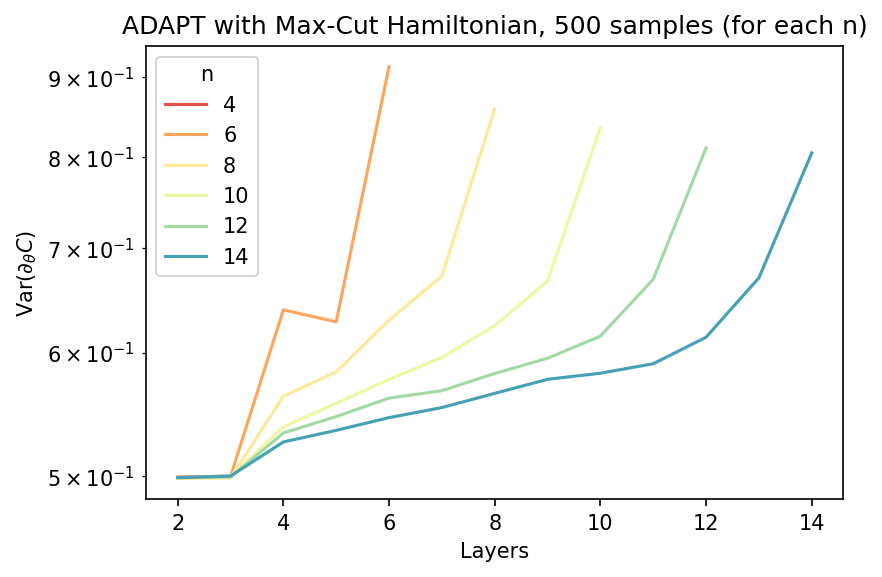

In [29]:

ax = sns.lineplot(
    data=df_stat_grad.grad_eval,
    x="layer",
    hue="num_qubits",
    y="var",
    palette=sns.color_palette("Spectral", n_colors=len(df_grad["num_qubits"].unique()))
)

ax.set_xlabel("Layers")
ax.set_ylabel(r'Var$(\partial_\theta C)$')
ax.set_yscale("log")
ax.legend().set_title("n")
ax.set_title(f"ADAPT with Max-Cut Hamiltonian, 500 samples (for each n)")